# [ EXPLORATION ] 9. 영화리뷰 텍스트 감성분석하기

✅imdb 영화 리뷰 평점 데이터를 토대로 사용자들의 리뷰 감성을 분류해 보는 실용적인 텍스트 분류 모델을 구현해본다.

---
### - 📖목차
* ✔️9-11. 프로젝트: 네이버 영화리뷰 감성분석
    <br>1-1. LSTM
    <br>1-2. 1-D CNN
    <br>1-3. GlobalMaxPooling1D
* ✔️한국어 Word2Vec 임베딩 활용하여 성능 개선
* ✔️미리 학습된 다른 한국어 임베딩들을 쓰면 성능이 더 좋아질까?
    <br>3-1. Fasttext + LSTM
    <br>3-2. Glove + LSTM
* ✔️기본 LSTM이 아닌 다른 모델과의 조합은 어떨까?
    <br>4-1. Fasttext + 1-D CNN
    <br>4-2. Bidirectional LSTM + Word2Vec
* ✔️회고 및 결론
* ✔️Reference(참고자료)

<br>



<br>

## ✔️9-11. 프로젝트: 네이버 영화리뷰 감성분석
---
### 1) 데이터 준비와 확인



In [2]:
# 모듈 로드
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [3]:
# matplotlib 한글
def fix_font():
    # From https://HC.Dle.pw, By Jinseo Kim
    # v1.0.0
    import os
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    os.system("apt-get install -y fonts-nanum")
    os.system("fc-cache -fv")
    mpl.font_manager._rebuild()
    findfont = mpl.font_manager.fontManager.findfont
    mpl.font_manager.findfont = findfont
    mpl.backends.backend_agg.findfont = findfont
    plt.rcParams['font.family'] = "NanumBarunGothic"
    plt.rcParams['axes.unicode_minus'] = False
           
fix_font()

In [ ]:
!pip install konlpy

In [5]:
# 데이터 불러오기
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# 파일 경로 확인(전체)
!ls '/content/gdrive/MyDrive/aiffel/ex_09/' 

cc.ko.300.bin.gz		       preprocess	  word2vec.txt
GoogleNews-vectors-negative300.bin.gz  preprocess.sh	  word-embeddings
ko.bin				       ratings_test.txt   word_eval.py
models				       ratings_train.txt


In [208]:
# 데이터 읽기
train_data = pd.read_table('/content/gdrive/MyDrive/aiffel/ex_09/ratings_train.txt')
test_data = pd.read_table('/content/gdrive/MyDrive/aiffel/ex_09/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [209]:
print("- train data 개수: {}, test data 개수: {}".format(len(train_data), len(test_data)))  # 데이터 개수 확인

- train data 개수: 150000, test data 개수: 50000


### 2) 데이터로더 구성

In [ ]:
# Mecab 동작을 위해 설치
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
# Mecab 동작을 위해 설치2 + 끝난 뒤에 런타임 재실행
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh

In [210]:
# 모듈 실행
from konlpy.tag import Okt, Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [211]:
def load_data(train_data, test_data, num_words=10000):
    # 특수문자 제거
    train_data['document'] = train_data['document'].str.replace(pat = r'[^\w]', repl=r'', regex=True)
    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # 공백은 Null로 변경
    train_data['document'].replace('', np.nan, inplace=True)
    # 결측치 제거
    train_data = train_data.dropna(how = 'any')
    
    # 특수문자 제거
    test_data['document'] = test_data['document'].str.replace(pat = r'[^\w]', repl=r'', regex=True)    
    # 중복 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    # 공백은 Null로 변경
    test_data['document'].replace('', np.nan, inplace=True)
    # 결측치 제거
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) #토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) #토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어 제거
        X_test.append(temp_X)
    
    # 단어 사전 만들기
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    # 리뷰 텍스트를 단어사전 인덱스로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

# 데이터셋 생성
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print('train data : {}, test data : {}'.format(len(X_train), len(X_test)))

# 인덱스:단어 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

train data : 143763, test data : 48535


In [212]:
#문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수. 
#모든 문장은 <BOS>로 시작해야 함. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

#여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

#숫자 벡터로 encode된 문장을 원래대로 decode하는 함수. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

#여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [213]:
#decode 된 문장과 라벨 비교 후 일치하는지 확인
for i in range(10):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('라벨: ', y_train[i])

[32, 70, 893, 33, 222, 15, 39, 2, 473]
더 빙 진짜 짜증 나 네 <UNK> 소리
라벨:  0
[1066, 493, 345, 653, 4, 112, 1577, 47, 789, 1014, 11, 38, 383]
포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
라벨:  1
[19, 167, 2]
재 <UNK>
라벨:  0
[8573, 144, 4237, 278, 92, 13, 5, 50, 3501]
이야기 구먼 솔직히 재미 없 다 평점 조정
라벨:  0
[2, 9132, 1054, 47, 2693, 54, 4, 2694, 34, 1142, 29, 325, 37, 17, 36, 54, 2, 392, 3442, 1717, 5]
익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> 너무나 이뻐 보였 다
라벨:  1
[713, 2, 2, 131, 414, 171, 1488, 666, 65, 1593, 715, 45, 446, 183, 265, 4, 62, 1400, 133, 751]
<UNK> <UNK> 3 세 부터 초등 학교 1 학년 생 인 8 살 용 영화 ㅋㅋㅋ 별반 개 아까움
라벨:  0
[237, 359, 8, 355, 1976, 53, 11, 805, 5]
긴장감 을 제대로 살려 내 지 못했 다
라벨:  0
[1400, 133, 147, 5, 442, 729, 2, 2, 47, 1456, 273, 91, 232, 24, 961, 22, 324, 593, 523, 483, 575, 5, 3169, 8574, 17, 1429, 1429, 66, 284, 13, 5, 47, 98, 7, 69, 17, 2, 39]
개 아깝 다 욕 나온다 <UNK> <UNK> 연기 생활 몇 년 인지 정말 발 로 해도 그것 보단 낫 겟 다 납치 감금 만 반복 반복 드라마 가족 없 다 연기 못 하 사람 만 <UNK> 네
라벨:  0
[120, 13, 18, 88, 273, 23, 43, 4]
없 는데 재미있 몇 안 되

### 3) 모델 구성을 위한 데이터 분석 및 가공

In [214]:
# 데이터셋 내 문장 길이 분포

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('- 문장길이 평균 : ', np.mean(num_tokens))
print('- 문장길이 최대 : ', np.max(num_tokens))
print('- 문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('- pad_sequences maxlen : ', maxlen)
print('- 전체 문장의 {}%가 maxlen 설정값 이내에 포함'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)*100))

- 문장길이 평균 :  13.837554212732321
- 문장길이 최대 :  105
- 문장길이 표준편차 :  11.558396063501716
- pad_sequences maxlen :  36
- 전체 문장의 93.27658113968944%가 maxlen 설정값 이내에 포함


In [215]:
# 적절한 최대 문장 길이 지정 : 최대 36 으로
# Keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                                     padding='post', maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

print(X_train.shape)

(143763, 36)


In [195]:
# post 버전으로는 다 학습해봤기 때문에 pre 패딩도 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                                     padding='pre', maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='pre',
                                       maxlen=maxlen)

print(X_train.shape)

(143763, 36)


- LMS에서는 RNN의 경우 입력데이터가 순차적으로 처리되기 대문에 마지막 입력이 무의미한 패딩으로 채워지는 post 보다 pre가 유리하며, 10퍼센트 가량 효율이 차이 난다는 문구가 있었다. 따라서 모든 학습이 끝난 상황이므로 몇가지 모델들만 추가적으로 같은 환경에서 pre 패딩 버전을 돌려보기로 결정했다.

<br>

### 4) 모델 구성 및 validation set 구성
-----
- 모델은 3가지 이상 다양하게 구성하려 실험하기

In [216]:
#훈련용 데이터셋 20000건을 가량을 분리하여 validation set
x_val = X_train[:20000]
y_val = y_train[:20000]

#validation set을 제외한 나머지는 train set
partial_x_train = X_train[20000:]
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(123763, 36)
(123763,)
(20000, 36)
(20000,)


<br>

#### 1-1. LSTM(Long Short Term Memory)
- LSTM은 기존의 RNN이 출력과 먼 위치에 있는 정보를 기억할 수 없다는 단점을 보완, 장/단기 기억을 가능하게 설계한 신경망의 구조. 시계열 처리나, 자연어 처리에 사용

In [14]:
# callback으로 조기종료 설정
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [217]:
# 1. LSTM
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

lstm.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, None, 16)          160000    
                                                                 
 lstm_23 (LSTM)              (None, 8)                 800       
                                                                 
 dense_56 (Dense)            (None, 8)                 72        
                                                                 
 dense_57 (Dense)            (None, 1)                 9         
                                                                 
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [16]:
# lstm 학습(post 패딩 버전)
lstm.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history = lstm.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[early_stopping],
                   verbose=1)

Epoch 1/10
203/203 [==============================] - 7s 27ms/step - loss: 0.5724 - accuracy: 0.6783 - val_loss: 0.4004 - val_accuracy: 0.8278
Epoch 2/10
203/203 [==============================] - 5s 23ms/step - loss: 0.3698 - accuracy: 0.8416 - val_loss: 0.3639 - val_accuracy: 0.8392
Epoch 3/10
203/203 [==============================] - 5s 23ms/step - loss: 0.3347 - accuracy: 0.8575 - val_loss: 0.3621 - val_accuracy: 0.8384
Epoch 4/10
203/203 [==============================] - 5s 23ms/step - loss: 0.3194 - accuracy: 0.8635 - val_loss: 0.3713 - val_accuracy: 0.8366
Epoch 5/10
203/203 [==============================] - 5s 23ms/step - loss: 0.3064 - accuracy: 0.8676 - val_loss: 0.3663 - val_accuracy: 0.8365
Epoch 6/10
203/203 [==============================] - 5s 24ms/step - loss: 0.2927 - accuracy: 0.8718 - val_loss: 0.3762 - val_accuracy: 0.8359
Epoch 7/10
203/203 [==============================] - 5s 24ms/step - loss: 0.2794 - accuracy: 0.8756 - val_loss: 0.3979 - val_accuracy: 0.8335

In [17]:
# test set으로 model 평가
results = lstm.evaluate(X_test,  y_test, verbose=2)
print(results)

1517/1517 - 3s - loss: 0.4078 - accuracy: 0.8277 - 3s/epoch - 2ms/step
[0.4078345000743866, 0.8276501297950745]


In [198]:
# lstm 학습(pre 패딩 버전)
lstm.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history = lstm.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[early_stopping],
                   verbose=1)

Epoch 1/10
242/242 [==============================] - 9s 29ms/step - loss: 0.5087 - accuracy: 0.7736 - val_loss: 0.3874 - val_accuracy: 0.8307
Epoch 2/10
242/242 [==============================] - 6s 27ms/step - loss: 0.3594 - accuracy: 0.8443 - val_loss: 0.3649 - val_accuracy: 0.8399
Epoch 3/10
242/242 [==============================] - 6s 27ms/step - loss: 0.3367 - accuracy: 0.8550 - val_loss: 0.3685 - val_accuracy: 0.8375
Epoch 4/10
242/242 [==============================] - 6s 27ms/step - loss: 0.3259 - accuracy: 0.8608 - val_loss: 0.3662 - val_accuracy: 0.8385
Epoch 5/10
242/242 [==============================] - 6s 27ms/step - loss: 0.3192 - accuracy: 0.8638 - val_loss: 0.3679 - val_accuracy: 0.8368
Epoch 6/10
242/242 [==============================] - 6s 26ms/step - loss: 0.3131 - accuracy: 0.8667 - val_loss: 0.3704 - val_accuracy: 0.8380
Epoch 6: early stopping


In [199]:
# test set으로 model 평가(pre 패딩 버전)
results = lstm.evaluate(X_test,  y_test, verbose=2)
print(results)

1517/1517 - 4s - loss: 0.3760 - accuracy: 0.8350 - 4s/epoch - 3ms/step
[0.3759710192680359, 0.8350056409835815]


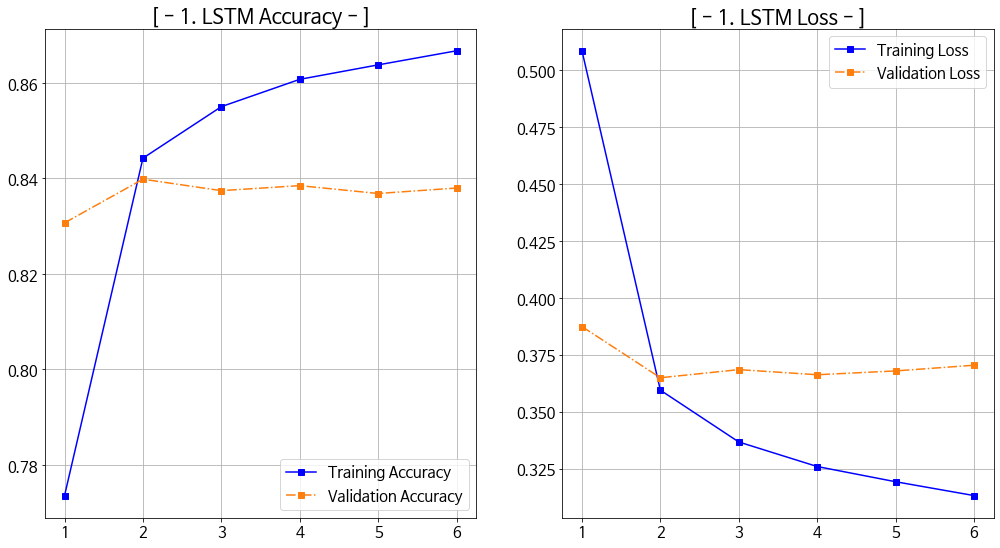

In [200]:
# 시각화할 항목 세팅
history_dict = history.history
acc_1 = history_dict['accuracy']
val_acc_1 = history_dict['val_accuracy']
loss_1 = history_dict['loss']
val_loss_1 = history_dict['val_loss']

epochs = range(1, len(acc_1) + 1)

# Accuracy 그래프
plt.figure(figsize=(17, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_1, 'b', marker='s', label='Training Accuracy')
plt.plot(epochs, val_acc_1, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('[ - 1. LSTM Accuracy - ]', fontsize='20')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_1, 'b', marker='s', label='Training Loss')
plt.plot(epochs, val_loss_1, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('[ - 1. LSTM Loss - ]', fontsize='20')
plt.show()

- 맨 처음 모델이기 때문에 크게 욕심 부리지 않았는데 그래도 로스값 0.4 정도에 정화고 0.82 정도의 무난한 결과가 나왔다. 다만 val_loss 값이 2에폭 때 이후 부터는 오히려 상승하기 시작했고, val_Accuracy 역시 더이상 올라가지 않았다는 점이 계속 신경쓰이게 만들었다.

- 이후 pre 패딩 버전을 추가해서 기본 LSTM 모델로 같이 돌려봤는데, 전혀 바뀐게 없는데도 불구하고 1퍼센트 가량의 상승폭이 있음을 확인했다.(확실히 NN의 순환 모델에서는 pre가 더 좋을 수도 있다는 생각에 다른 기본모델들도 더 돌려보기로 했다.)

<br>

#### 1-2. 1-D CNN
- 1차원 CNN은 이미지가 아닌 시계열 분석(time-series analysis)나 텍스트 분석을 하는데 주로 많이 사용. 자연어 처리에 사용되는 1D 합성곱 연산에서도 입력이 되는 것은 각 단어가 벡터로 변환된 문장 행렬로 LSTM과 입력을 받는 형태는 동일.

In [218]:
# 1-D CNN
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
d_cnn = keras.Sequential()
d_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
d_cnn.add(keras.layers.Conv1D(16, 3, activation='relu'))
d_cnn.add(keras.layers.MaxPooling1D(5))
d_cnn.add(keras.layers.Conv1D(16, 3, activation='relu'))
d_cnn.add(keras.layers.GlobalMaxPooling1D())
d_cnn.add(keras.layers.Dense(8, activation='relu'))
d_cnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

d_cnn.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, None, 16)          160000    
                                                                 
 conv1d_32 (Conv1D)          (None, None, 16)          784       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_33 (Conv1D)          (None, None, 16)          784       
                                                                 
 global_max_pooling1d_9 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_58 (Dense)            (None, 8)               

In [219]:
# 1-D_cnn 학습(post 패딩 버전)
d_cnn.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history = d_cnn.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[early_stopping],
                   verbose=1)

Epoch 1/10
242/242 [==============================] - 3s 8ms/step - loss: 0.4968 - accuracy: 0.7632 - val_loss: 0.3702 - val_accuracy: 0.8334
Epoch 2/10
242/242 [==============================] - 2s 8ms/step - loss: 0.3395 - accuracy: 0.8515 - val_loss: 0.3632 - val_accuracy: 0.8375
Epoch 3/10
242/242 [==============================] - 2s 8ms/step - loss: 0.3057 - accuracy: 0.8708 - val_loss: 0.3631 - val_accuracy: 0.8411
Epoch 4/10
242/242 [==============================] - 2s 8ms/step - loss: 0.2792 - accuracy: 0.8839 - val_loss: 0.3706 - val_accuracy: 0.8389
Epoch 5/10
242/242 [==============================] - 2s 8ms/step - loss: 0.2536 - accuracy: 0.8969 - val_loss: 0.3810 - val_accuracy: 0.8371
Epoch 6/10
242/242 [==============================] - 2s 8ms/step - loss: 0.2277 - accuracy: 0.9100 - val_loss: 0.3993 - val_accuracy: 0.8367
Epoch 7/10
242/242 [==============================] - 2s 8ms/step - loss: 0.2013 - accuracy: 0.9227 - val_loss: 0.4272 - val_accuracy: 0.8332
Epoch 

In [220]:
# test set으로 1-D_cnn 평가(post 패딩 버전)
results = d_cnn.evaluate(X_test,  y_test, verbose=2)
print(results)

1517/1517 - 2s - loss: 0.4330 - accuracy: 0.8293 - 2s/epoch - 1ms/step
[0.43298807740211487, 0.8293190598487854]


In [203]:
# 1-D_cnn 학습(pre 패딩 버전)
d_cnn.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history = d_cnn.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[early_stopping],
                   verbose=1)

Epoch 1/10
242/242 [==============================] - 3s 8ms/step - loss: 0.5905 - accuracy: 0.6687 - val_loss: 0.5024 - val_accuracy: 0.7306
Epoch 2/10
242/242 [==============================] - 2s 8ms/step - loss: 0.4690 - accuracy: 0.7576 - val_loss: 0.4895 - val_accuracy: 0.7383
Epoch 3/10
242/242 [==============================] - 2s 8ms/step - loss: 0.4344 - accuracy: 0.7783 - val_loss: 0.4933 - val_accuracy: 0.7405
Epoch 4/10
242/242 [==============================] - 2s 8ms/step - loss: 0.4059 - accuracy: 0.7948 - val_loss: 0.5057 - val_accuracy: 0.7354
Epoch 5/10
242/242 [==============================] - 2s 8ms/step - loss: 0.3789 - accuracy: 0.8098 - val_loss: 0.5268 - val_accuracy: 0.7332
Epoch 6/10
242/242 [==============================] - 2s 8ms/step - loss: 0.3519 - accuracy: 0.8241 - val_loss: 0.5464 - val_accuracy: 0.7319
Epoch 6: early stopping


In [204]:
# test set으로 1-D_cnn 평가(pre 패딩 버전)
results = d_cnn.evaluate(X_test,  y_test, verbose=2)
print(results)

1517/1517 - 2s - loss: 0.5525 - accuracy: 0.7316 - 2s/epoch - 1ms/step
[0.5524541139602661, 0.7316163778305054]


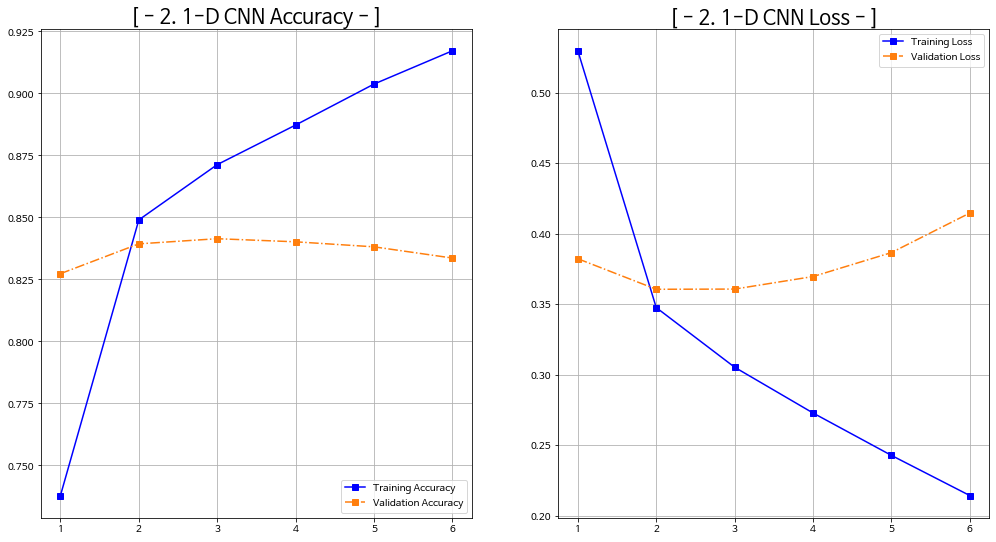

In [24]:
# 1-D_cnn 시각화할 항목 세팅
history_dict = history.history
acc_2 = history_dict['accuracy']
val_acc_2 = history_dict['val_accuracy']
loss_2 = history_dict['loss']
val_loss_2 = history_dict['val_loss']

epochs = range(1, len(acc_2) + 1)

# Accuracy 그래프
plt.figure(figsize=(17, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_2, 'b', marker='s', label='Training Accuracy')
plt.plot(epochs, val_acc_2, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('[ - 2. 1-D CNN Accuracy - ]', fontsize='20')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_2, 'b', marker='s', label='Training Loss')
plt.plot(epochs, val_loss_2, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('[ - 2. 1-D CNN Loss - ]', fontsize='20')
plt.show()

- 1-D CNN의 경우 원래 CV쪽에서 많이 쓰이는걸 1차원적으로 만들어서 모델을 쓴다는 것 자체도 신기했는데, 의외로 정확도가 0.83에 로스값이 0.42 정도가 나와서 앞서 봤던 LSTM과 꽤 흡사하다는걸 확인할 수 있었다.

- 하지만 패딩에서는 달랐던 게, post 패딩 버전에서는 0.83 정도 되뎐 val_accuracy의 경우 오히려 0.73으로 떨어지고 val_loss 도 0.5 정도로 확 올라간게 눈에 띄었다. 앞서 봤던 LSTM이랑은 전혀 상반된 결과였다.

<br>

#### 1-3. GlobalMaxPooling1D
- 여러 개의 벡터 정보 중 가장 큰 벡터를 골라서 반환.  글로벌 맥스풀링(GlobalMaxPooling1D) 레이어는 컨볼루션 레이어가 문장을 훑어가면서 나온 특징벡터들 중 가장 큰 벡터를 골라주며, 문맥을 보면서 주요 특징을 뽑아내고 가장 두드러지는 특징을 고른다.

In [205]:
# GlobalMaxPooling1D
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
gmp_1d = keras.Sequential()
gmp_1d.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp_1d.add(keras.layers.GlobalMaxPooling1D())
gmp_1d.add(keras.layers.Dense(8, activation='relu'))
gmp_1d.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

gmp_1d.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, None, 16)          160000    
                                                                 
 global_max_pooling1d_8 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_54 (Dense)            (None, 8)                 136       
                                                                 
 dense_55 (Dense)            (None, 1)                 9         
                                                                 
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [26]:
# GlobalMaxPooling1D (post 패딩 버전)
gmp_1d.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history = gmp_1d.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[early_stopping],
                   verbose=1)

Epoch 1/10
203/203 [==============================] - 2s 5ms/step - loss: 0.6078 - accuracy: 0.7496 - val_loss: 0.4645 - val_accuracy: 0.8117
Epoch 2/10
203/203 [==============================] - 1s 5ms/step - loss: 0.4028 - accuracy: 0.8288 - val_loss: 0.3801 - val_accuracy: 0.8288
Epoch 3/10
203/203 [==============================] - 1s 5ms/step - loss: 0.3460 - accuracy: 0.8520 - val_loss: 0.3667 - val_accuracy: 0.8356
Epoch 4/10
203/203 [==============================] - 1s 4ms/step - loss: 0.3155 - accuracy: 0.8670 - val_loss: 0.3654 - val_accuracy: 0.8377
Epoch 5/10
203/203 [==============================] - 1s 4ms/step - loss: 0.2925 - accuracy: 0.8780 - val_loss: 0.3694 - val_accuracy: 0.8372
Epoch 6/10
203/203 [==============================] - 1s 4ms/step - loss: 0.2736 - accuracy: 0.8874 - val_loss: 0.3764 - val_accuracy: 0.8377
Epoch 7/10
203/203 [==============================] - 1s 4ms/step - loss: 0.2571 - accuracy: 0.8947 - val_loss: 0.3851 - val_accuracy: 0.8371
Epoch 

In [27]:
# test set으로 model 평가
results = gmp_1d.evaluate(X_test,  y_test, verbose=2)
print(results)

1517/1517 - 1s - loss: 0.4064 - accuracy: 0.8297 - 1s/epoch - 763us/step
[0.4063724875450134, 0.8297311067581177]


In [206]:
# GlobalMaxPooling1D (pre 패딩 버전)
gmp_1d.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history = gmp_1d.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[early_stopping],
                   verbose=1)

Epoch 1/10
242/242 [==============================] - 2s 5ms/step - loss: 0.5929 - accuracy: 0.7054 - val_loss: 0.4451 - val_accuracy: 0.8131
Epoch 2/10
242/242 [==============================] - 1s 4ms/step - loss: 0.3923 - accuracy: 0.8314 - val_loss: 0.3777 - val_accuracy: 0.8310
Epoch 3/10
242/242 [==============================] - 1s 4ms/step - loss: 0.3418 - accuracy: 0.8526 - val_loss: 0.3698 - val_accuracy: 0.8370
Epoch 4/10
242/242 [==============================] - 1s 4ms/step - loss: 0.3156 - accuracy: 0.8655 - val_loss: 0.3719 - val_accuracy: 0.8357
Epoch 5/10
242/242 [==============================] - 1s 4ms/step - loss: 0.2968 - accuracy: 0.8750 - val_loss: 0.3767 - val_accuracy: 0.8355
Epoch 6/10
242/242 [==============================] - 1s 4ms/step - loss: 0.2817 - accuracy: 0.8811 - val_loss: 0.3836 - val_accuracy: 0.8342
Epoch 7/10
242/242 [==============================] - 1s 4ms/step - loss: 0.2689 - accuracy: 0.8882 - val_loss: 0.3928 - val_accuracy: 0.8339
Epoch 

In [207]:
# test set으로 model 평가(pre 패딩 버전)
results = gmp_1d.evaluate(X_test,  y_test, verbose=2)
print(results)

1517/1517 - 1s - loss: 0.3991 - accuracy: 0.8321 - 1s/epoch - 751us/step
[0.3991013169288635, 0.8321417570114136]


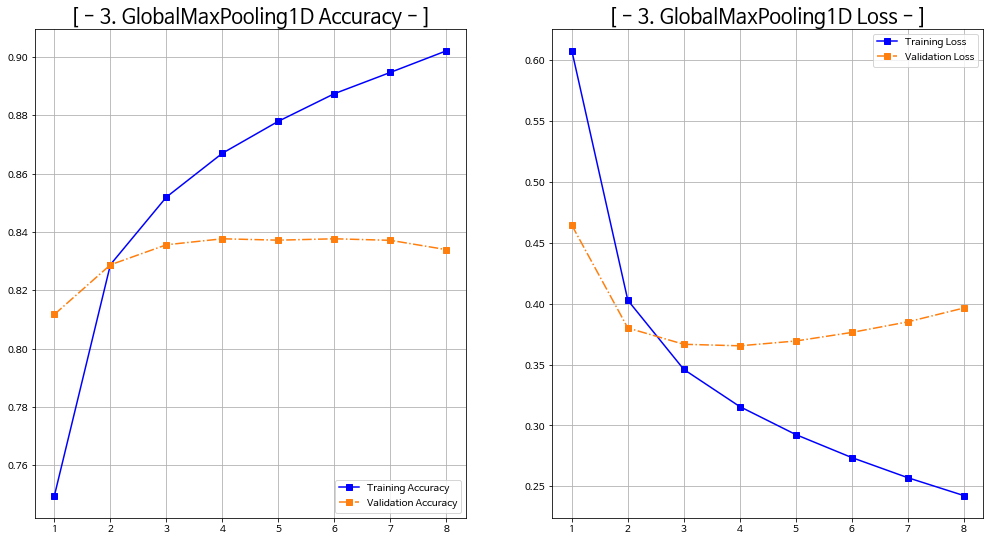

In [28]:
# 시각화할 항목 세팅
history_dict = history.history
acc_3 = history_dict['accuracy']
val_acc_3 = history_dict['val_accuracy']
loss_3 = history_dict['loss']
val_loss_3 = history_dict['val_loss']

epochs = range(1, len(acc_3) + 1)

# Accuracy 그래프
plt.figure(figsize=(17, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_3, 'b', marker='s', label='Training Accuracy')
plt.plot(epochs, val_acc_3, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('[ - 3. GlobalMaxPooling1D Accuracy - ]', fontsize='20')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_3, 'b', marker='s', label='Training Loss')
plt.plot(epochs, val_loss_3, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('[ - 3. GlobalMaxPooling1D Loss - ]', fontsize='20')
plt.show()

- GlobalMaxPooling1D의 경우 로스값 0.40 정도에 정확도 0.82정도로 앞서 봤던 다른 모델들과 견주어 봤을때 보편적인 치수가 나왔다. 이는 세 모델이 비등비등한 성능을 가지고 있다고 가정할때, 다른 상황에서 어떻게 튜닝해서 쓰느냐가 관건이 된다는 의미로 받아들였다.

- 하지만 CNN이랑 결과가 비슷할거라고 생각했던 pre 패딩 결과의 경우, 오히려 여기서 0.1퍼센트가 더 상승한 결과를 보여줘서 묘하게 아이러니 했다. 오히려 여기서도 수치가 떨어지지 않고 올랐다는 점에서는 눈여겨 볼 만 하다.

<br>

### 7) 학습된 Embedding 레이어 분석

In [19]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

In [20]:
# 임베딩 레이어 차원 확인
embedding_layer = lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [21]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = '/content/gdrive/MyDrive/aiffel/ex_09/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("재미")  # 학습이 잘 되지 않아 별로 유사하지 않음

[('완전', 0.9250794053077698),
 ('너무', 0.8995237350463867),
 ('진짜', 0.8888211250305176),
 ('특색', 0.8840250968933105),
 ('긴장감', 0.8802157044410706),
 ('넘', 0.8768340349197388),
 ('케', 0.8699100613594055),
 ('스타뎀', 0.8693494200706482),
 ('이리', 0.8675895929336548),
 ('가치', 0.864504873752594)]

In [32]:
word_vectors.similar_by_word("웃음") 

[('는데', 0.8453035354614258),
 ('지만', 0.7863641381263733),
 ('읽', 0.7618289589881897),
 ('클', 0.7612184286117554),
 ('않', 0.761198878288269),
 ('길래', 0.760887622833252),
 ('리즈', 0.7601195573806763),
 ('엉뚱', 0.7490211725234985),
 ('자세히', 0.7477170825004578),
 ('지려', 0.7412337064743042)]

- 최종적으로 학습된 word2Vec 파일을 같이 가지고 와서 벡터간의 유사도를 판별했을때, 생각보다 학습이 잘 되지 않은 탓인지 재미나 웃음이라는 단어의 유사도를 찾을 때 그렇게까지 연관 있는 단어들을 찾아내지 못했다. 직접 학습하는 것은 엄청나게 많은 데이터들을 넣지 않는 한 분명 한계가 있고, 따라서 이제부터는 기존의 임베딩 벡터들을 불러와서 모델에 학습해 결과를 적용해보기로 결정했다.

<br>
<br>

## ✔️8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
---
- ko.bin을 찾아 이용 > gensim 버전을 3.x.x로 낮춰야 오류가 일어나지 않음에 유의



영어 이외의 미리 학습된 임베딩은 https://github.com/Kyubyong/wordvectors 에서 찾을 수 있다. 한국어 Word2Vec은 Korean (w)라는 링크에서 다운 받을 수 있다. ko.zip을 다운받아 압축을 풀면 50MB 가량의 ko.bin 파일이 생긴다. 이 파일은 .load로 불러들일 수 있다.

In [34]:
!pip install --upgrade gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.2 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 4.2.0
    Uninstalling gensim-4.2.0:
      Successfully uninstalled gensim-4.2.0


In [134]:
from gensim.models import KeyedVectors

word2vec_path = '/content/gdrive/MyDrive/aiffel/ex_09/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector.shape     # 200dim의 워드 벡터

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(200,)

In [23]:
# 유사한 단어와 그 유사도 확인
word2vec.wv.most_similar("재미")  # 학습이 잘 되어 유사함

[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [135]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000     # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


<br>

#### - 4. Word2Vec(한글) 임베딩 + LSTM

- 미리 훈련된 한글버전의 Word2Vec과 LSTM은 가장 베이직하면서도 LMS 노드상에서도 있는 심플한 버전이었기 때문에 부담없이 모델을 구축해 돌려보기로 했다. 

In [138]:
# Word2Vec 임베딩 + LSTM 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dropout(rate=0.4)) #dropout 추가
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 36, 200)           2000000   
                                                                 
 lstm_16 (LSTM)              (None, 128)               168448    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_29 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [139]:
# Word2Vec 임베딩 + LSTM 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/10
1934/1934 [==============================] - 128s 65ms/step - loss: 0.4621 - accuracy: 0.7590 - val_loss: 0.3541 - val_accuracy: 0.8456
Epoch 2/10
1934/1934 [==============================] - 126s 65ms/step - loss: 0.3182 - accuracy: 0.8612 - val_loss: 0.3287 - val_accuracy: 0.8541
Epoch 3/10
1934/1934 [==============================] - 126s 65ms/step - loss: 0.2760 - accuracy: 0.8823 - val_loss: 0.3308 - val_accuracy: 0.8561
Epoch 4/10
1934/1934 [==============================] - 128s 66ms/step - loss: 0.2394 - accuracy: 0.8998 - val_loss: 0.3489 - val_accuracy: 0.8552
Epoch 5/10
1934/1934 [==============================] - 126s 65ms/step - loss: 0.2056 - accuracy: 0.9156 - val_loss: 0.3629 - val_accuracy: 0.8570
Epoch 6/10
1934/1934 [==============================] - 126s 65ms/step - loss: 0.1725 - accuracy: 0.9304 - val_loss: 0.3776 - val_accuracy: 0.8543
Epoch 6: early stopping


In [140]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)   # 정확도가 0.85으로 개선됨

1517/1517 - 18s - loss: 0.3786 - accuracy: 0.8524 - 18s/epoch - 12ms/step
[0.3785964250564575, 0.8523539900779724]


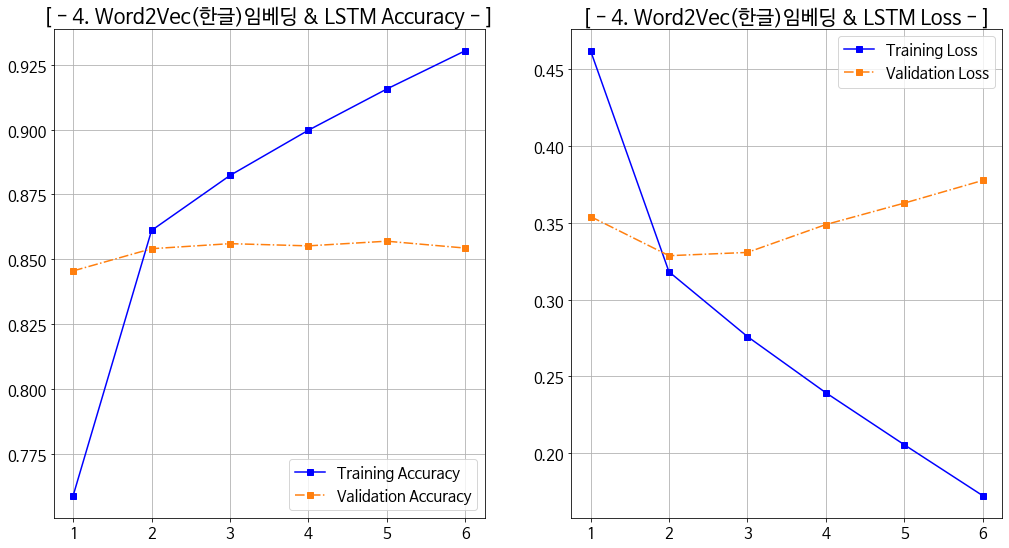

In [141]:
# 시각화할 항목 세팅
history_dict = history.history
acc_4 = history_dict['accuracy']
val_acc_4 = history_dict['val_accuracy']
loss_4 = history_dict['loss']
val_loss_4 = history_dict['val_loss']

epochs = range(1, len(acc_4) + 1)

# Accuracy 그래프
plt.figure(figsize=(17, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_4, 'b', marker='s', label='Training Accuracy')
plt.plot(epochs, val_acc_4, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('[ - 4. Word2Vec(한글)임베딩 & LSTM Accuracy - ]', fontsize='20')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_4, 'b', marker='s', label='Training Loss')
plt.plot(epochs, val_loss_4, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('[ - 4. Word2Vec(한글)임베딩 & LSTM Loss - ]', fontsize='20')
plt.show()

- 기존 LSTM 모델의 경우 정확도가 0.82 정도가 나왔는데, word2Vec의 경우 동일한 조건에서 3퍼센트 정도 상승한 수치가 나왔다. val_accuracy로 나오는 정확도의 경우 추가적으로 떨어지진 않았으나 여전히 val_loss 값이 올라가는 건 개선의 여지가 필요해 보인다.

<br>
<br>

## ✔️미리 학습된 다른 한국어 임베딩들을 쓰면 성능이 더 좋아질까?
---
### - 학습된 한국어 임베딩 파일들을 확보하기



![20220606225248](https://user-images.githubusercontent.com/100528803/172175432-c24a683b-90a2-4f78-8342-5f6141a3bf58.png)

가지고 있는 자연어처리 책 중에서 '한국어 임베딩'이라는 제목의 서적이 있었는데, 그 책에 단어 임베딩들을 미리 학습해둔 파일들이 있어서 따로 다운받았다.(사실 구글링에서도 충분히 나올 수 있는 자료라 아래 레퍼런스로 첨부했습니다)

- 그와 별개로 책 자체의 내용도 괜찮아서 공부해볼 만하다고 생각함

In [11]:
# fasttext 사용을 위해서 모듈 다운
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.4 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3143671 sha256=9c805cb9837a76232df5f6821dbb179aac9f737fcc319675461b1eedf43a4837
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


- 사실 fasttext의 경우는 개인적으로 이번 프로젝트에서 가장 고생을 많이 한 경우다. 일단 모델 자체가 따로 있기 때문에 케라스에서의 연결이 까다로웠던 것도 있지만, 무엇보다 모듈 설치 자체가 Fasttext인지, fastText인지, FastText 인지 일일히 다 구분하면서 쳐봐야 했기 때문이다. 나중에 pre-model을 쓴다면 좀더 제대로 된 메뉴얼이 필요하다고 생각했다.

In [29]:
# fasttext의 학습된 모델 불러오기(3~4분 정도 소요)
from gensim import models

ko_model = models.fasttext.load_facebook_model('/content/gdrive/MyDrive/aiffel/ex_09/cc.ko.300.bin.gz')

In [30]:
# 재미와 연관된 단어 학습들을 미루어볼 때, 제대로 학습된 것을 확인
for w, sim in ko_model.wv.most_similar('재미'):
    print(f'{w}: {sim}')

실콕스: 0.7009633183479309
통쾌함: 0.5585301518440247
쏠쏠: 0.549235463142395
재미가: 0.547288179397583
재미와: 0.5217501521110535
재미는: 0.5210652947425842
흥미: 0.5164767503738403
재미도: 0.5036113262176514
찾아나요: 0.48469895124435425
향하고보기는: 0.4844211935997009


In [31]:
# 각 단어들끼리의 유사도를 확인
print(f"- '꿈'과 '희망'의 유사도: {ko_model.wv.similarity('꿈', '희망')}")
print(f"- '슬픔'과 '우울'의 유사도: {ko_model.wv.similarity('슬픔', '우울')}")

- '꿈'과 '희망'의 유사도: 0.4053809344768524
- '슬픔'과 '우울'의 유사도: 0.4495983421802521


앞서 우리가 직접 학습했던 임베딩에 비해서 가중치가 제대로 들어간 것을 확인할 수 있었다. 재미라는 단어를 기본적으로 두고 한눈에 보기에도 연관된 단어들이 모두 나오는 것을 확인할 수 있었고, 각각의 유사도도 문제 없이 도출되는 것을 확인할 수 있었다.

<br>

#### - 벡터들끼리의 유사도 측정하기

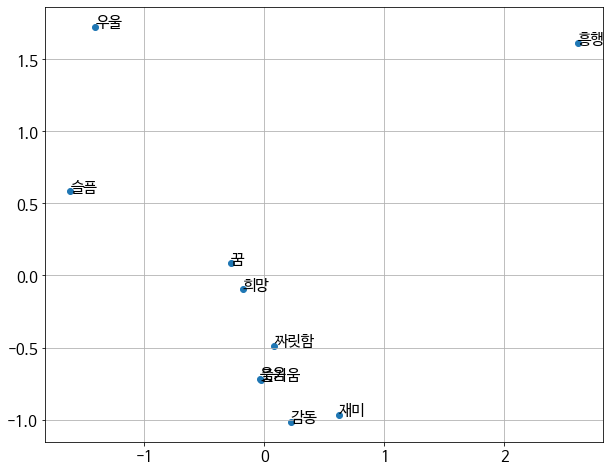

In [34]:
# 벡터들끼리의 유사도 측정하기
from sklearn.decomposition import PCA

words = [
    '웃음',
    '슬픔',
    '재미',
    '짜릿함',
    '흥행', 
    '꿈', 
    '희망',
    '우울',
    '감동',
    '즐거움'
]

# 학습된 단어들의 벡터를 통해서 비슷한 단어들끼리의 거리를 측정 가능
plt.rc('font', size=15)
pca = PCA(n_components=2)
xys = pca.fit_transform([ko_model.wv.word_vec(w) for w in words])
xs = xys[:,0]
ys = xys[:,1]
plt.figure(figsize=(10, 8))
plt.scatter(xs, ys, marker='o')
plt.grid()
for i, v in enumerate(words):
    plt.annotate(v, xy=(xs[i], ys[i]))

- 사실 pre-model로서 도출할 수 있는 정도는 이 정도였고, 우리는 모델을 직접 학습해서 돌려야하기 때문에 정상적으로 학습이 진행될 경우 이렇게 비슷한 뜻을 가지는 벡터들끼리 유사도가 높아 가까운 지점에 있다는 정도만 확인하면 오케이였다.

<br>

In [144]:
# 최대 길이 똑같이 36으로 설정
max_len = 36
tokenizer = Tokenizer()
vocabulary = tokenizer.word_index

In [75]:
# 모델 기본적으로 미리 세팅
from keras.models import Sequential
from keras.layers import Embedding

model = Sequential()
model.add(Embedding(vocab_size, 128, input_length = max_len))

<br>

#### 3-1. Fasttext 한글 Embedding
- 페이스북에서 개발한 텍스트 임베딩 기법. word2vec과 유사하나 word2vec은 한 단어를 더 이상 쪼개질 수 없는 최소 단위라 생각한다면, fastText는 각 단어를 character 단위 n-gram으로 쪼갠다. 내부 단어를 고려한 학습으로 word2Vec의 한계를 보완.

In [178]:
# 미리 학습된 상태의 Fasttext 임베딩 벡터를 불러오기 
from gensim.models.keyedvectors import KeyedVectors
FastText = KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/aiffel/ex_09/word-embeddings/fasttext/fasttext.vec', binary = False, unicode_errors='ignore')

In [179]:
embedding_matrix = np.zeros((vocab_size, 200)) #200차원의 임베딩 매트릭스 생성

for index, word in enumerate(vocabulary): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in word2vec: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = word2vec[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[i] = embedding_vector #해당 위치의 embedding_mxtrix에 저장합니다.

In [180]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000     # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [168]:
# Fasttext-LSTM 모델 생성
fasttext_m = keras.Sequential()
fasttext_m.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
fasttext_m.add(keras.layers.LSTM(128))
fasttext_m.add(keras.layers.Dense(8, activation='relu'))
fasttext_m.add(keras.layers.Dropout(rate=0.4)) #dropout 추가
fasttext_m.add(keras.layers.Dense(1, activation='sigmoid'))

fasttext_m.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 36, 200)           2000000   
                                                                 
 lstm_21 (LSTM)              (None, 128)               168448    
                                                                 
 dense_36 (Dense)            (None, 8)                 1032      
                                                                 
 dropout_9 (Dropout)         (None, 8)                 0         
                                                                 
 dense_37 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [169]:
# Fasttext-LSTM 모델 학습 진행
fasttext_m.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 10 에폭

history = fasttext_m.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/10
1934/1934 [==============================] - 132s 67ms/step - loss: 0.5579 - accuracy: 0.6865 - val_loss: 0.3756 - val_accuracy: 0.8351
Epoch 2/10
1934/1934 [==============================] - 129s 67ms/step - loss: 0.3799 - accuracy: 0.8438 - val_loss: 0.3425 - val_accuracy: 0.8484
Epoch 3/10
1934/1934 [==============================] - 129s 67ms/step - loss: 0.3290 - accuracy: 0.8673 - val_loss: 0.3358 - val_accuracy: 0.8536
Epoch 4/10
1934/1934 [==============================] - 128s 66ms/step - loss: 0.2922 - accuracy: 0.8845 - val_loss: 0.3478 - val_accuracy: 0.8540
Epoch 5/10
1934/1934 [==============================] - 129s 67ms/step - loss: 0.2590 - accuracy: 0.9004 - val_loss: 0.3811 - val_accuracy: 0.8539
Epoch 6/10
1934/1934 [==============================] - 129s 67ms/step - loss: 0.2276 - accuracy: 0.9148 - val_loss: 0.3724 - val_accuracy: 0.8514
Epoch 7/10
1934/1934 [==============================] - 129s 67ms/step - loss: 0.2000 - accuracy: 0.9273 - val_loss: 0

In [149]:
# 테스트셋을 통한 모델 평가(128이었을 때)
results = fasttext_m.evaluate(X_test,  y_test, verbose=2)
print(results)   

1517/1517 - 17s - loss: 0.4691 - accuracy: 0.8486 - 17s/epoch - 11ms/step
[0.4691210687160492, 0.8486040830612183]


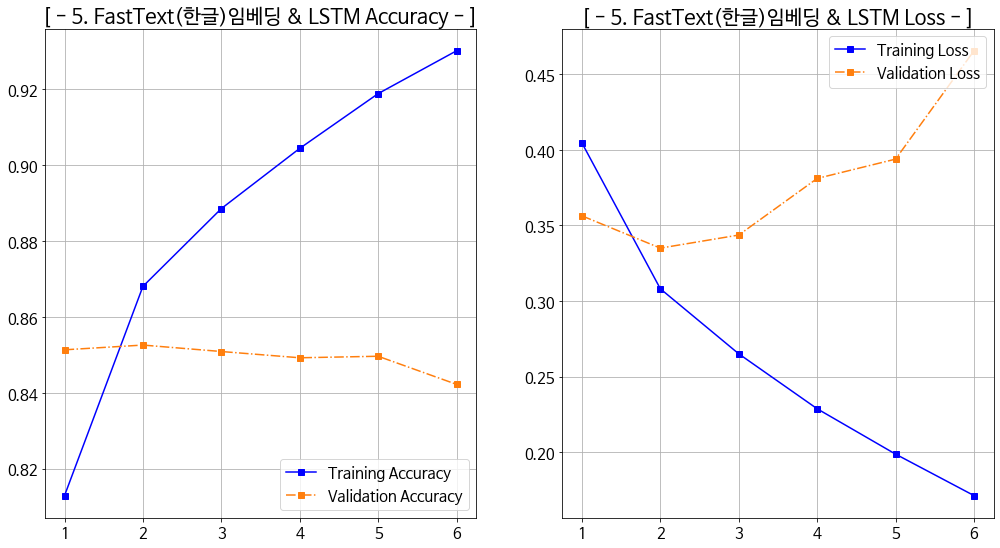

In [164]:
# 시각화할 항목 세팅
history_dict = history.history
acc_5 = history_dict['accuracy']
val_acc_5 = history_dict['val_accuracy']
loss_5 = history_dict['loss']
val_loss_5 = history_dict['val_loss']

epochs = range(1, len(acc_5) + 1)

# Accuracy 그래프
plt.figure(figsize=(17, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_5, 'b', marker='s', label='Training Accuracy')
plt.plot(epochs, val_acc_5, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('[ - 5. FastText(한글)임베딩 & LSTM Accuracy - ]', fontsize='20')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_5, 'b', marker='s', label='Training Loss')
plt.plot(epochs, val_loss_5, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('[ - 5. FastText(한글)임베딩 & LSTM Loss - ]', fontsize='20')
plt.show()

- 같은 LSTM의 조건에서 돌렸는데 에폭 10 정도에서 배치사이즈 64로 바꾸니까 드디어 85를 달성할 수 있었다. 로스 값은 0.37 정도로 가장 낮았기 때문에 뒤이어 나올 두 임베딩과 비교했을 때 전혀 밀리지 않는 성능을 보여줬다.

#### 3-2. Glove(한글)Embedding + LSTM
- 글로브(Global Vectors for Word Representation, GloVe)는 카운트 기반과 예측 기반을 모두 사용하는 방법론으로 2014년에 미국 스탠포드대학에서 개발한 단어 임베딩 방법.

In [152]:
# Glove 임베딩 불러오기
embedding_dict = dict()
f = open(os.path.join('/content/gdrive/MyDrive/aiffel/ex_09/word-embeddings/glove/glove.txt'), encoding='utf-8')
for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:]) # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()

print('- %s개의 Embedding vector가 있습니다.' % len(embedding_dict))

- 358043개의 Embedding vector가 있습니다.


In [153]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000     # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [154]:
# 임베딩 테이블의 크기 맞추기
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
print('- 임베딩 테이블의 크기(shape) :',np.shape(embedding_matrix))

- 임베딩 테이블의 크기(shape) : (10000, 200)


In [155]:
# 사실 위의 Glove 임베딩 불러오기랑 같은 건데.... 위 아래로 임베딩 들어갈 때 묘하게 엇갈리는 거 같아서 테스트로 하나 더 추가함
glove = dict()
f = open('/content/gdrive/MyDrive/aiffel/ex_09/word-embeddings/glove/glove.txt')
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:]) #, dtype='float32'
    glove[word] = vector
f.close()

In [156]:
embedding_matrix = np.zeros((vocab_size, 200)) #200차원의 임베딩 매트릭스 생성

for index, word in enumerate(vocabulary): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in glove: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = glove[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[i] = embedding_vector #해당 위치의 embedding_mxtrix에 저장합니다.
    else:
        print("glove 없는 단어입니다.")
        break

In [160]:
# Glove-LSTM 모델 생성
glove_m = keras.Sequential()
glove_m.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
glove_m.add(keras.layers.LSTM(128))
glove_m.add(keras.layers.Dropout(rate=0.4)) #dropout 추가
glove_m.add(keras.layers.Dense(1, activation='sigmoid'))

glove_m.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 36, 200)           2000000   
                                                                 
 lstm_20 (LSTM)              (None, 128)               168448    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [161]:
# Glove-LSTM 모델 학습 진행
glove_m.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = glove_m.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/10
1934/1934 [==============================] - 129s 66ms/step - loss: 0.4046 - accuracy: 0.8129 - val_loss: 0.3564 - val_accuracy: 0.8513
Epoch 2/10
1934/1934 [==============================] - 126s 65ms/step - loss: 0.3081 - accuracy: 0.8680 - val_loss: 0.3350 - val_accuracy: 0.8526
Epoch 3/10
1934/1934 [==============================] - 127s 65ms/step - loss: 0.2650 - accuracy: 0.8885 - val_loss: 0.3437 - val_accuracy: 0.8508
Epoch 4/10
1934/1934 [==============================] - 126s 65ms/step - loss: 0.2286 - accuracy: 0.9044 - val_loss: 0.3811 - val_accuracy: 0.8492
Epoch 5/10
1934/1934 [==============================] - 126s 65ms/step - loss: 0.1986 - accuracy: 0.9188 - val_loss: 0.3939 - val_accuracy: 0.8496
Epoch 6/10
1934/1934 [==============================] - 127s 66ms/step - loss: 0.1712 - accuracy: 0.9301 - val_loss: 0.4656 - val_accuracy: 0.8422
Epoch 6: early stopping


In [162]:
# 테스트셋을 통한 모델 평가
results = glove_m.evaluate(X_test,  y_test, verbose=2)
print(results)   

1517/1517 - 18s - loss: 0.4749 - accuracy: 0.8400 - 18s/epoch - 12ms/step
[0.474907249212265, 0.839971125125885]


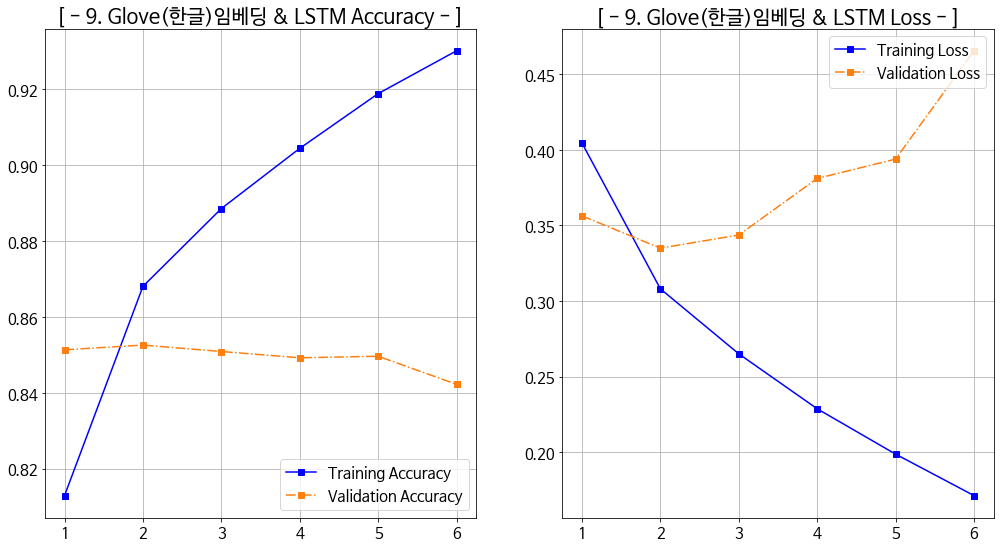

In [163]:
# 시각화할 항목 세팅
history_dict = history.history
acc_9 = history_dict['accuracy']
val_acc_9 = history_dict['val_accuracy']
loss_9 = history_dict['loss']
val_loss_9 = history_dict['val_loss']

epochs = range(1, len(acc_9) + 1)

# Accuracy 그래프
plt.figure(figsize=(17, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_9, 'b', marker='s', label='Training Accuracy')
plt.plot(epochs, val_acc_9, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('[ - 9. Glove(한글)임베딩 & LSTM Accuracy - ]', fontsize='20')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_9, 'b', marker='s', label='Training Loss')
plt.plot(epochs, val_loss_9, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('[ - 9. Glove(한글)임베딩 & LSTM Loss - ]', fontsize='20')
plt.show()

- Glove를 쓴 한글 임베딩의 경우 같은 LSTM 모델을 기준으로 했을 때 val_loss 값은 0.47, accuray는 0.84를 기록했기 때문에 생각보다 다른 모델에 비해서 소폭 높은 결과를 보여줬다. 세 종류의 한글 임베딩 모두 근소한 차가 있긴 했지만, 어느 하나 확 떨어지는 경우는 없었다.

<br>
<br>

## ✔️기본 LSTM이 아닌 다른 모델과의 조합은 어떨까?
-----
#### 4-1. Fasttext(한글)임베딩 +  1-D CNN 모델

In [183]:
# Fasttext(한글)임베딩 +  1-D CNN 모델 생성
vocab_size = 10000
word_vector_dim = 36

cnn_f = keras.Sequential()
cnn_f.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_f.add(keras.layers.Conv1D(36, 3, activation='relu'))
cnn_f.add(keras.layers.MaxPooling1D(5))
cnn_f.add(keras.layers.Conv1D(36, 3, activation='relu'))
cnn_f.add(keras.layers.GlobalMaxPooling1D())
cnn_f.add(keras.layers.Dense(8, activation='relu'))
cnn_f.add(keras.layers.Dense(1, activation='sigmoid'))

cnn_f.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, None, 36)          360000    
                                                                 
 conv1d_28 (Conv1D)          (None, None, 36)          3924      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 36)         0         
 1D)                                                             
                                                                 
 conv1d_29 (Conv1D)          (None, None, 36)          3924      
                                                                 
 global_max_pooling1d_6 (Glo  (None, 36)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_48 (Dense)            (None, 8)               

In [184]:
# Fasttext(한글)임베딩 +  1-D CNN 모델 학습
cnn_f.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history = cnn_f.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_data=(x_val, y_val),
                   callbacks=[early_stopping],
                   verbose=1)

Epoch 1/10
1934/1934 [==============================] - 12s 6ms/step - loss: 0.3959 - accuracy: 0.8147 - val_loss: 0.3479 - val_accuracy: 0.8483
Epoch 2/10
1934/1934 [==============================] - 11s 6ms/step - loss: 0.2935 - accuracy: 0.8755 - val_loss: 0.3524 - val_accuracy: 0.8460
Epoch 3/10
1934/1934 [==============================] - 11s 6ms/step - loss: 0.2262 - accuracy: 0.9087 - val_loss: 0.3786 - val_accuracy: 0.8431
Epoch 4/10
1934/1934 [==============================] - 11s 6ms/step - loss: 0.1648 - accuracy: 0.9366 - val_loss: 0.4401 - val_accuracy: 0.8379
Epoch 5/10
1934/1934 [==============================] - 11s 6ms/step - loss: 0.1184 - accuracy: 0.9556 - val_loss: 0.5289 - val_accuracy: 0.8292
Epoch 5: early stopping


In [185]:
results = cnn_f.evaluate(X_test,  y_test, verbose=2)
print(results)

1517/1517 - 2s - loss: 0.5226 - accuracy: 0.8303 - 2s/epoch - 1ms/step
[0.5226315259933472, 0.830328643321991]


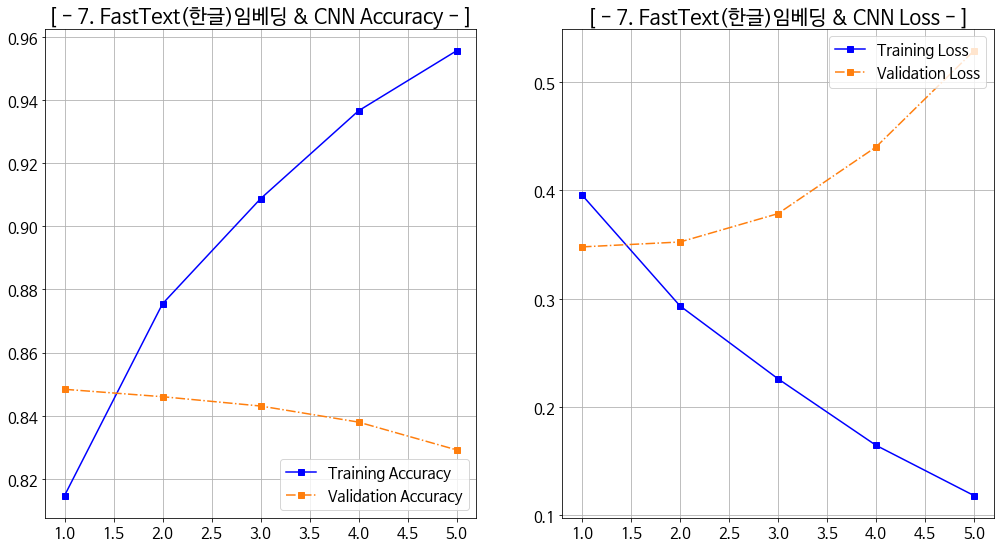

In [186]:
# 시각화할 항목 세팅
history_dict = history.history
acc_7 = history_dict['accuracy']
val_acc_7 = history_dict['val_accuracy']
loss_7 = history_dict['loss']
val_loss_7 = history_dict['val_loss']

epochs = range(1, len(acc_7) + 1)

# Accuracy 그래프
plt.figure(figsize=(17, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_7, 'b', marker='s', label='Training Accuracy')
plt.plot(epochs, val_acc_7, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('[ - 7. FastText(한글)임베딩 & CNN Accuracy - ]', fontsize='20')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_7, 'b', marker='s', label='Training Loss')
plt.plot(epochs, val_loss_7, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('[ - 7. FastText(한글)임베딩 & CNN Loss - ]', fontsize='20')
plt.show()

- FastText와 1-D CNN 조합의 경우 val_loss값 0.53과 더불어 정확도가 0.82 정도로 오히려 기본적인 LSTM 모델보다 소폭 떨어진 값을 보여줬다. 나중에 pre 패딩으로 한다면 다른 값이 나올까 고민되게 만들었는데, 다른 모델에 비해서 빠른 속도가 그나마 강점으로 남은 조합이었다.

<br>

#### 4-2. Word2Vec(한글)임베딩 + Bidirectional LSTM 모델
- Bidirectinal 재귀 신경망은 Bidirectional 래퍼 클래스로 LSTM이나 RNN, GRU와 같은 재귀적 신경모델을 감싸주는 모델들로, 일방향이 아닌 양방향 재귀모델로 분류된다.

In [125]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

In [142]:
# Word2Vec(한글)임베딩 + Bidirectional LSTM 모델 생성
vocab_size = 10000
word_vector_dim = 36

b_lstm = keras.Sequential()
b_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
b_lstm.add(keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences = False), input_shape = (49,1)))
b_lstm.add(keras.layers.Dropout(rate=0.4))
b_lstm.add(keras.layers.Dense(8, activation='relu'))
b_lstm.add(keras.layers.Dense(1, activation='sigmoid'))

b_lstm.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, None, 36)          360000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 40)               9120      
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_30 (Dense)            (None, 8)                 328       
                                                                 
 dense_31 (Dense)            (None, 1)                 9         
                                                                 
Total params: 369,457
Trainable params: 369,457
Non-trainable params: 0
_______________________________________________

In [143]:
# Word2Vec(한글)임베딩 + Bidirectional LSTM 모델 학습
b_lstm.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history = b_lstm.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_data=(x_val, y_val),
                   callbacks=[early_stopping],
                   verbose=1)

Epoch 1/10
1934/1934 [==============================] - 46s 22ms/step - loss: 0.4096 - accuracy: 0.8105 - val_loss: 0.3505 - val_accuracy: 0.8434
Epoch 2/10
1934/1934 [==============================] - 41s 21ms/step - loss: 0.3283 - accuracy: 0.8565 - val_loss: 0.3423 - val_accuracy: 0.8455
Epoch 3/10
1934/1934 [==============================] - 43s 22ms/step - loss: 0.2949 - accuracy: 0.8730 - val_loss: 0.3503 - val_accuracy: 0.8469
Epoch 4/10
1934/1934 [==============================] - 41s 21ms/step - loss: 0.2687 - accuracy: 0.8854 - val_loss: 0.3606 - val_accuracy: 0.8438
Epoch 5/10
1934/1934 [==============================] - 41s 21ms/step - loss: 0.2463 - accuracy: 0.8957 - val_loss: 0.3828 - val_accuracy: 0.8446
Epoch 6/10
1934/1934 [==============================] - 44s 23ms/step - loss: 0.2274 - accuracy: 0.9049 - val_loss: 0.4064 - val_accuracy: 0.8449
Epoch 6: early stopping


In [170]:
results = b_lstm.evaluate(X_test,  y_test, verbose=2)
print(results)

1517/1517 - 6s - loss: 0.4090 - accuracy: 0.8438 - 6s/epoch - 4ms/step
[0.40900641679763794, 0.843762218952179]


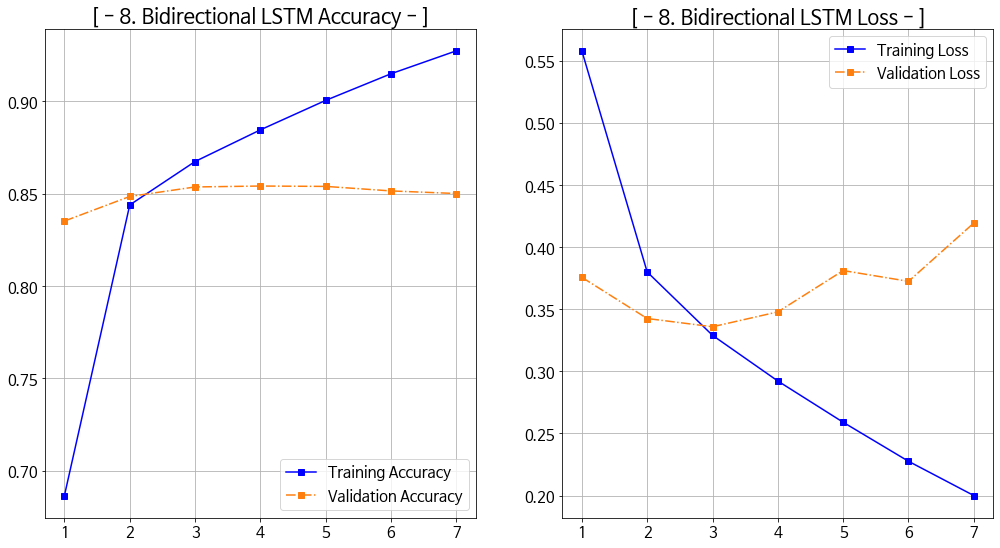

In [171]:
# 시각화할 항목 세팅
history_dict = history.history
acc_8 = history_dict['accuracy']
val_acc_8 = history_dict['val_accuracy']
loss_8 = history_dict['loss']
val_loss_8 = history_dict['val_loss']

epochs = range(1, len(acc_8) + 1)

# Accuracy 그래프
plt.figure(figsize=(17, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_8, 'b', marker='s', label='Training Accuracy')
plt.plot(epochs, val_acc_8, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('[ - 8. Bidirectional LSTM Accuracy - ]', fontsize='20')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_8, 'b', marker='s', label='Training Loss')
plt.plot(epochs, val_loss_8, color='#ff7f0e', linestyle='-.', marker='s', label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('[ - 8. Bidirectional LSTM Loss - ]', fontsize='20')
plt.show()

- Bidirectional LSTM의 경우 일방향이 아닌 양방향이라서 기대가 컸는데, 같은 조건을 위한 Word2Vec 임베딩을 적용했을 경우 로스값 0.43 정도에 정확도 0.84로 괄목할만한 정도는 아니었다. 사실 이것은 모델 자체의 성능보다는 내가 특성을 제대로 이해 못하고 세팅한게 아닌가 한번쯤 뒤돌아보게 만들었다.

<br>

## ✔️회고 및 결론
---

#### ▶️ 이번 프로젝트에서 어려웠던 점

오히려 LMS노드를 따라가는 과정 자체에서는 어려운 게 없었는데, 본격적인 헬게이트의 시작은 다른 임베딩 벡터들을 대입해서 모델을 만드는 과정이었다. 이 과정들 중에서도 서로 차원이나 벡터, 숫자가 다를 경우에는 가차없이 에러가 튀어나오기 때문에 하나씩 확인하면서 맞추는 과정이 쉽지 않았다. 그럼에도 Word2Vec과 비슷한 결과가 나왔다는 점 역시도 제대로 학습된 임베딩 벡터를 적용 못한게 아닌가 고민되게 만들었다. 

<br>

#### ▶️ 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

![다운로드](https://user-images.githubusercontent.com/100528803/172185425-f3411fd6-688e-4986-8cbb-4b86fd67d75f.png)

미리 훈련된 FastText 모델에서 유사도가 가까운 단어들을 뽑아내는 과정이 신기하면서도 이정도의 정확성이 나오려면 얼만큼의 학습이 필요한지를 뒤돌아보게 만들었다. 우리가 직접 만든 모델의 경우 제대로 수를 잡아내지도 못하는 반면에, 모델이 이렇게까지 학습을 잘한 모습을 보니 전의를 다시 다지게 만들었다.

![Untitled-1](https://user-images.githubusercontent.com/100528803/172187097-4cb12c90-371b-404d-8565-c7c9728ba7df.png)

실제로 각각의 임베딩별 가중치 차이를 위해서 하나씩 단어별 유사도를 가져왔는데, '재미'라는 단어를 기준으로 했을 때, 직접 학습시킨 임베딩의 경우 제대로 단어를 짚어내지 못하고 우왕좌왕하는 걸 볼 수 있는 반면에 Word2Vec의 경우 어느정도 비슷한 단어들을 꼽아내는 걸 확인할 수 있었다. 마지막으로 학습된 FastText 모델에서 나온 단어들은 거의 흡사한 단어들을 용도에 따라 잡아내는 걸 보면서 좀 더 정교한 성능을 보여줬다.(하지만 정작 모델에서는 비슷한 수치에 그쳤다는 데서 모델에서 내가 성능을 끌어내지 못한게 아닌가 고민하게 했다)

<br>

#### ▶️ 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트에서 루브릭의 기준은 아래와 같았다.

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.<br>                                 | 3가지 이상의 모델이 성공적으로 시도됨<br>                                                        |
| **2** | gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.<br> | gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함                               |
| **3** | 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.                                    | 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함 |

![20220607001657](https://user-images.githubusercontent.com/100528803/172190789-3b669ecc-d813-4de4-95be-5f21f5508ae0.png)

In [226]:
print(f'- [ Word2Vec + LSTM ]모델과 임베딩 조합의 경우 Accuracy [{val_acc_4*100: .2f}% ]를 달성했습니다.')

- [ Word2Vec + LSTM ]모델과 임베딩 조합의 경우 Accuracy [ 85.24% ]를 달성했습니다.


모델 자체는 LMS상의 기본모델 3개 + Word2Vec 임베딩 하나 + 각 임베딩별 LSTM의 성능 3종류와 마지막으로 재귀 신경망까지 더해 8가지를 선택했다. 그중에서 WOrd2Vec과 LSTM 조합이 85 퍼센트로 제일 높았고, 1-D CNN과 Pre 패딩의 조합이 가장 낮았다. 전체적으로 비등비등하게 무난한 수치가 나와서 아쉬움이 들었는데, 90을 목표로 이것저것 돌려봤던 입장에서는 루브릭을 모두 충족하긴 했지만 조금의 아쉬움이 남는다. 이건 이후 NLP 공부를 하면서 채워나가야 할 부분 같다.

<br>

## ✔️Reference(참고자료)
---
* https://ratsgo.github.io/embedding/downloaddata.html
* https://github.com/zutshianand/Conversational-Chatbot/blob/152fb74b073f077272312720f73066b42a29b58a/main.ipynb
* https://github.com/zutshianand/Conversational-Chatbot/blob/152fb74b073f077272312720f73066b42a29b58a/main.ipynb
* https://github.com/hmcgovern/offens-eval/blob/90877ee232dae612065bba39d2615d6c1c8494c9/main.ipynb
* https://github.com/Hello79/ESAA/blob/6fa5b496c0515a57ad294bb47c352a435f1a0407/0927_seoyeon_1.ipynb
* https://frhyme.github.io/nlp/fasttext_pretrained_wiki/
* https://inahjeon.dev/fasttext/